In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import timm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

batch_size = 512
num_workers = 8

model_name = 'vit_base_patch16_224'
pretrained = True
num_classes = 10

device_gpu = 'cuda:2'

label_smoothing = 0.1
learning_rate = 0.001
epochs = 20

In [3]:
# 데이터 증강을 위한 전처리
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 무작위 크기 및 비율로 자르기
    transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
    transforms.RandomRotation(15),      # -15도에서 15도 사이로 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변경
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainloader), len(testloader)

(98, 20)

In [5]:
model = timm.create_model(model_name=model_name, 
                          pretrained=pretrained, 
                          num_classes=num_classes)

device = torch.device(device_gpu if torch.cuda.is_available() else "cpu")
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [6]:
criterion1 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
criterion2 = nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate*2, total_steps=epochs*len(trainloader))

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Epoch 1, Loss: 0.8819839115045509, Val Loss: 0.1377784725278616, Duration: 357.01 sec
Epoch 2, Loss: 0.72121619570012, Val Loss: 0.14404858313500882, Duration: 356.47 sec
Epoch 3, Loss: 0.697787208216531, Val Loss: 0.15327971279621125, Duration: 356.39 sec
Epoch 4, Loss: 0.6948607728189352, Val Loss: 0.1289434865117073, Duration: 359.26 sec
Epoch 5, Loss: 0.6833030885579635, Val Loss: 0.1385004237294197, Duration: 358.95 sec
Epoch 6, Loss: 0.6740003666099237, Val Loss: 0.1319704070687294, Duration: 357.43 sec
Epoch 7, Loss: 0.6716810379709516, Val Loss: 0.1423417329788208, Duration: 358.40 sec
Epoch 8, Loss: 0.6629364162075276, Val Loss: 0.14216474778950214, Duration: 356.40 sec
Epoch 9, Loss: 0.6572984937502413, Val Loss: 0.13430914655327797, Duration: 356.48 sec
Early stopping


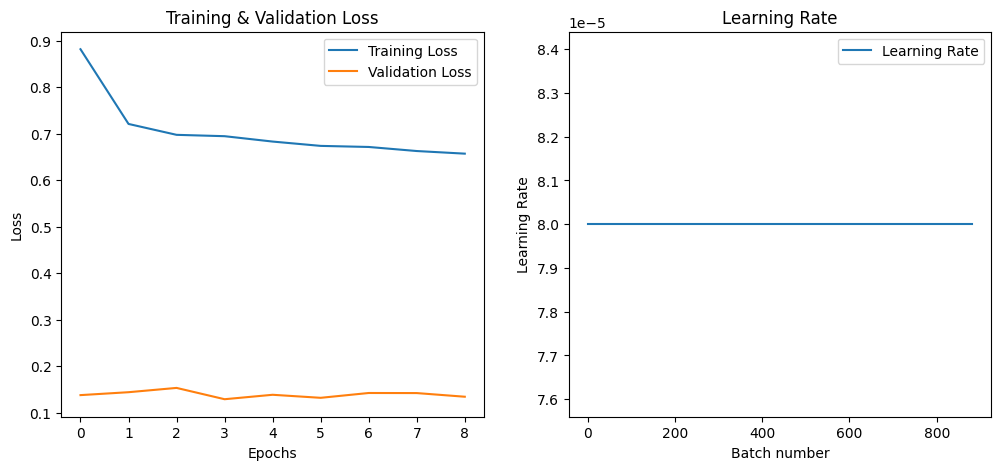

In [8]:
from tqdm import tqdm

training_time = 0
early_stopping = EarlyStopping(patience=5)
losses = []
val_losses = []
lrs = []
best_val_loss = float('inf')

model_path = 'best_model.pth'  # 모델 저장 경로
model_save = False

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch + 1}")
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        lrs.append(optimizer.param_groups[0]["lr"])
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # 검증 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(testloader)
    val_losses.append(val_loss)

    # 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save = True
        torch.save(model.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    if model_save:
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Val Loss: {val_loss}, Duration: {epoch_duration:.2f} sec - model saved!')
        model_save = False
    else :
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Val Loss: {val_loss}, Duration: {epoch_duration:.2f} sec')

    # Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Batch number')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()
